<a href="https://colab.research.google.com/github/Saadman53/Thesis-Human-Action-Recognition/blob/main/Human_Action_Recognition_using_Sensor_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [189]:
from google.colab import drive
drive.mount('/content/drive')
gdrive_path = "drive/My Drive/Dataset/all_data.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [190]:
!pip install minepy
!pip install sklearn_relief
!pip install sklearn-genetic
!pip install info_gain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from minepy import MINE
from sklearn.feature_selection import mutual_info_regression
import scipy

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from scipy.special import entr
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import differential_entropy
from scipy.stats import entropy

from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F


from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

from genetic_selection import GeneticSelectionCV
from sklearn.tree import DecisionTreeClassifier

from sklearn.feature_selection import mutual_info_regression
from info_gain import info_gain

import random
from sklearn.metrics import confusion_matrix, recall_score, precision_score


import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report


from torch.utils.data import DataLoader, ConcatDataset
# from torchvision import transforms
from sklearn.model_selection  import StratifiedKFold
%matplotlib inline

In [192]:
df = pd.read_csv(gdrive_path)
df.tail()

,Unnamed: 0,0_mean_x,0_var_x,0_kurt_x,0_max_x,0_min_x,0_dc_comp_x,0_spec_energy_x,0_spec_entropy_x,0_max_psd_x,...,9_dc_comp_m,9_spec_energy_m,9_spec_entropy_m,9_max_psd_m,9_min_psd_m,9_min_max_psd_m,9_max_xas_m,9_min_xas_m,9_min_max_xas_m,activity
1160,1160,-0.054506,0.001862,-0.040152,0.072510,-0.149658,4178.914871,15331.889818,3.857213,0.420883,...,1.338846e+06,1.511391e+09,6.555544,0.113631,3.274603e-09,2.881788e-08,0.337092,0.000057,0.000170,9
1161,1161,-0.026696,0.002853,5.849030,0.427002,-0.189697,842.076824,1492.626785,5.105730,0.373887,...,1.131603e+06,1.178036e+09,6.289649,0.097086,1.527362e-08,1.573198e-07,0.311587,0.000124,0.000397,9
1162,1162,-0.038772,0.001957,37.360906,0.555176,-0.434082,1766.442641,2957.616036,6.873023,0.149166,...,1.123454e+06,1.164343e+09,6.877409,0.068606,6.772243e-08,9.871164e-07,0.261928,0.000260,0.000994,9
1163,1163,-0.084045,0.001579,-0.482562,0.028564,-0.166016,9406.587377,77108.344139,3.375543,0.413470,...,1.274956e+06,1.408591e+09,6.892931,0.061177,1.379768e-08,2.255369e-07,0.247340,0.000117,0.000475,9
1164,1164,-0.043714,0.001209,0.021406,0.071533,-0.119873,1880.480207,3743.618849,3.326524,0.543291,...,9.423824e+05,8.952466e+08,6.628678,0.059656,1.391945e-07,2.333289e-06,0.244246,0.000373,0.001528,9


In [193]:
def train_test_val_split(df,n_classes, target, test_prob = 0.2):
  test_prob = 0.2
  test_samples = []
  val_samples = []
  train_samples = []
  for i in range(n_classes):
    indices = list(df[df[target]==(i+1)].index.values)
    size = len(indices)
    test_sample = random.sample(indices,int(size*test_prob))
    train_sample = list(np.setdiff1d(indices,test_sample)) #subtract test samples from whole set
    val_sample = random.sample(train_sample,int(len(train_sample)*test_prob))
    train_sample = list(np.setdiff1d(train_sample,val_sample)) #subtract validation samples from train
    test_samples.extend(test_sample)
    val_samples.extend(val_sample)
    train_samples.extend(train_sample)
  X = df.drop([target], axis = 1).copy()
  y = df[target].copy()
  X_train = X.iloc[train_samples]
  y_train = y.iloc[train_samples]
  X_val = X.iloc[val_samples]
  y_val = y.iloc[val_samples]
  X_test = X.iloc[test_samples]
  y_test = y.iloc[test_samples]
  return X_train, X_test, X_val, y_train, y_test, y_val

In [194]:
df.drop(df.columns[df.isna().any()].tolist(), axis = 1, inplace = True)
df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [195]:
X = df.drop(['activity'], axis = 1)
y = df['activity']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=42, stratify = y)
#X_train_val, X_test, y_train_val, y_test = train_test_split(X, y,test_size=0.3, random_state=42, stratify = y)
#X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,test_size=0.1, random_state=21,  stratify = y_train_val)
features = X.columns

In [196]:
#X_train, X_test, X_val, y_train, y_test, y_val = train_test_val_split(df,22, "activity", 0.2)

In [197]:
features = X_train.columns

In [198]:
#relief f
from sklearn.metrics.pairwise import pairwise_distances
def reliefF(X, y, **kwargs):
    """
    This function implements the reliefF feature selection
    Input
    -----
    X: {numpy array}, shape (n_samples, n_features)
        input data
    y: {numpy array}, shape (n_samples,)
        input class labels
    kwargs: {dictionary}
        parameters of reliefF:
        k: {int}
            choices for the number of neighbors (default k = 5)
    Output
    ------
    score: {numpy array}, shape (n_features,)
        reliefF score for each feature
    Reference
    ---------
    Robnik-Sikonja, Marko et al. "Theoretical and empirical analysis of relieff and rrelieff." Machine Learning 2003.
    Zhao, Zheng et al. "On Similarity Preserving Feature Selection." TKDE 2013.
    """

    if "k" not in kwargs.keys():
        k = 5
    else:
        k = kwargs["k"]
    n_samples, n_features = X.shape

    # calculate pairwise distances between instances
    distance = pairwise_distances(X, metric='manhattan')

    score = np.zeros(n_features)

    # the number of sampled instances is equal to the number of total instances
    for idx in range(n_samples):
        near_hit = []
        near_miss = dict()

        self_fea = X[idx, :]
        c = np.unique(y).tolist()

        stop_dict = dict()
        for label in c:
            stop_dict[label] = 0
        del c[c.index(y[idx])]

        p_dict = dict()
        p_label_idx = float(len(y[y == y[idx]]))/float(n_samples)

        for label in c:
            p_label_c = float(len(y[y == label]))/float(n_samples)
            p_dict[label] = p_label_c/(1-p_label_idx)
            near_miss[label] = []

        distance_sort = []
        distance[idx, idx] = np.max(distance[idx, :])

        for i in range(n_samples):
            distance_sort.append([distance[idx, i], int(i), y[i]])
        distance_sort.sort(key=lambda x: x[0])

        for i in range(n_samples):
            # find k nearest hit points
            if distance_sort[i][2] == y[idx]:
                if len(near_hit) < k:
                    near_hit.append(distance_sort[i][1])
                elif len(near_hit) == k:
                    stop_dict[y[idx]] = 1
            else:
                # find k nearest miss points for each label
                if len(near_miss[distance_sort[i][2]]) < k:
                    near_miss[distance_sort[i][2]].append(distance_sort[i][1])
                else:
                    if len(near_miss[distance_sort[i][2]]) == k:
                        stop_dict[distance_sort[i][2]] = 1
            stop = True
            for (key, value) in stop_dict.items():
                    if value != 1:
                        stop = False
            if stop:
                break

        # update reliefF score
        near_hit_term = np.zeros(n_features)
        for ele in near_hit:
            near_hit_term = np.array(abs(self_fea-X[ele, :]))+np.array(near_hit_term)

        near_miss_term = dict()
        for (label, miss_list) in near_miss.items():
            near_miss_term[label] = np.zeros(n_features)
            for ele in miss_list:
                near_miss_term[label] = np.array(abs(self_fea-X[ele, :]))+np.array(near_miss_term[label])
            score += near_miss_term[label]/(k*p_dict[label])
        score -= near_hit_term/k
    return score


def feature_ranking(score):
    """
    Rank features in descending order according to reliefF score, the higher the reliefF score, the more important the
    feature is
    """
    idx = np.argsort(score, 0)
    return idx[::-1]
def selected_features(X, score):
  ranked_features = feature_ranking(score)
  sel_feat = []
  for i in range(X.shape[1]):
    if(ranked_features[i]>0):
      sel_feat.append(ranked_features[i])
    else:
      break
  return X.columns[np.array(sel_feat)]


In [199]:
##symmetrical uncertainty
def SU(df, X,Y):
  if(Y=='activity'):
    IG = mutual_info_classif(np.transpose(np.array([df[X]])), df[Y]).item()
    H_Y = entropy(df[Y])
  else:
    IG = mutual_info_regression(np.transpose(np.array([df[X]])), df[Y]).item()
    H_Y = differential_entropy(df[Y])
  H_X = differential_entropy(df[X])
  su = ((2.0*IG)/(H_X+H_Y))
  return su
 
def MI(df, X,Y):
  if(Y=='activity'):
    MI = mutual_info_classif(np.transpose(np.array([df[X]])), df[Y]).item()
  else:
    MI = mutual_info_regression(np.transpose(np.array([df[X]])), df[Y]).item()
  return MI

def MIC_feature_selection(X_train, y_train):
  scores = {}
  mine = MINE(alpha=0.6, c=15, est="mic_approx")
  for i in range(X_train.shape[1]):
    mic_score = mine.compute_score(X_train.iloc[:,i], y_train).mic()
    scores.append(mic_score)
    res = pd.Series(np.array(scores),index = features).sort_values(ascending=False)
  return res
# res[res>0.60].index.values

def SU_feature_selection(X_train, y_train):
  df_train = df.iloc[X_train.index].copy()
  scores = []
  #print("SU:\nCol\tScore")
  for col in df_train.columns:
    if col!='activity':
      #print(col+":")
      score = SU(df_train, col, 'activity')
      scores.append(score)
      #print(score)
  ser = pd.Series(np.array(scores),index = features).sort_values(ascending=False)
  return ser[ser>0.0].index.values

#Fast Correlation Based Filter
def FCBF(df, features, C):
  thresh = 0.000001
  N = len(features)
  S_list = {}
  for i in range(N):
    val = SU(df, features[i], C)
    if(val> thresh):
      S_list[features[i]] = val
  S_list = pd.Series(S_list).sort_values(ascending=False)
  no_features = S_list.shape[0]
  a_list = np.ones(no_features)
  for i in range(no_features):
    if(a_list[i]==1):
      Fp = S_list.index[i]
      for j in range(i+1,no_features):
        if(a_list[j]==1):
          Fq = S_list.index[j]
          if(SU(df, Fp,Fq) >= S_list[j]):
            #print(f"{j} has been eleminated while in {i}")
            a_list[j]=0
  idx = np.where(a_list==1)[0]
  return S_list.index[idx]

def random_forest_feature_selection(X_train, y_train):
  sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
  sel.fit(X_train, y_train)
  sel.get_support()
  selected_features_rf= X_train.columns[(sel.get_support())].values
  return selected_features_rf

def reliefF_feature_selection(X_train, y_train):
  score = reliefF(X_train.to_numpy(),y_train.to_numpy())
  selected_features_relief = selected_features(X_train,score).values
  return selected_features_relief

def genetic_feature_selection(X_train, y_train):
  estimator = DecisionTreeClassifier()
  model = GeneticSelectionCV(
      estimator, cv=5, verbose=0,
      scoring="accuracy", max_features=100,
      n_population=100, crossover_proba=0.5,
      mutation_proba=0.2, n_generations=50,
      crossover_independent_proba=0.5,
      mutation_independent_proba=0.04,
      tournament_size=3, n_gen_no_change=10,
      caching=True, n_jobs=-1)
  model = model.fit(X_train,y_train)
  selected_features_genetic = X_train.columns[model._get_support_mask()].values
  return selected_features_genetic

def mutual_information_feature_selection(X_train, y_train):
  mi_scores = mutual_info_regression(X_train, y_train, discrete_features=False)
  mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_train.columns)
  mi_scores = mi_scores.sort_values(ascending=False)
  selected_features_info_gain = mi_scores[mi_scores>0.5].index.values
  return selected_features_info_gain

def information_gain_feature_selection(X_train, y_train):
  scores = []
  for i in range(X_train.shape[1]):
    score = info_gain.info_gain(X_train.iloc[:,i], y_train )
    scores.append(score)
    #print(X_train.columns[i],score) [res>0.60].index.values
  res = pd.Series(np.array(scores),index = features).sort_values(ascending=False)
  return res[res>3.0].index.values
def gain_ratio_feature_selection(X_train, y_train):
  gain_ratio = []
  #print("Gain Ratio:\nCol\tScore")
  for i in range(X_train.shape[1]):
    score = info_gain.info_gain_ratio(X_train.iloc[:,i], y_train )
    gain_ratio.append(score)
    #print(X_train.columns[i],score)
  res = pd.Series(np.array(gain_ratio),index = features).sort_values(ascending=False)
  return res[res>0.60].index.values

def chi2_feature_selection(X_train1,y_train):
  scaler = MinMaxScaler()
  X_train1 = scaler.fit_transform(X_train)
  from sklearn.feature_selection import chi2
  chi_scores = chi2(X_train1,y_train)
  p_values = pd.Series(chi_scores[1],index = X_train.columns)
  p_values.sort_values(ascending = False , inplace = True)
  selected_features_chi = p_values[p_values>0.5].index.values
  return selected_features_chi

In [200]:
information_gain_feature_selection(X_train, y_train)

array(['3_max_m', '0_mean_x', '6_min_psd_y', '6_min_max_psd_z',
       '6_min_psd_z', '6_max_psd_z', '6_spec_entropy_z',
       '6_spec_energy_z', '6_dc_comp_z', '6_kurt_z', '6_var_z',
       '6_mean_z', '6_min_max_xas_y', '6_min_xas_y', '6_max_xas_y',
       '6_min_max_psd_y', '6_max_psd_y', '6_dc_comp_x',
       '6_spec_entropy_y', '6_spec_energy_y', '6_dc_comp_y', '6_kurt_y',
       '6_var_y', '6_mean_y', '6_min_max_xas_x', '6_min_xas_x',
       '6_max_xas_x', '6_min_max_psd_x', '6_min_psd_x', '6_max_psd_x',
       '6_spec_entropy_x', '6_max_xas_z', '6_min_xas_z',
       '6_min_max_xas_z', '7_var_x', '7_dc_comp_y', '7_kurt_y', '7_var_y',
       '7_mean_y', '7_min_max_xas_x', '7_min_xas_x', '7_max_xas_x',
       '7_min_max_psd_x', '7_min_psd_x', '7_max_psd_x', '7_spec_energy_x',
       '7_dc_comp_x', '7_kurt_x', '7_mean_x', '6_mean_m',
       '6_min_max_xas_m', '6_min_xas_m', '6_max_xas_m', '6_min_max_psd_m',
       '6_min_psd_m', '6_max_psd_m', '6_spec_entropy_m',
       '6_spec_ene

In [201]:
def EFS_MI(df, X_train, y_train):
  selected_feature_list = [gain_ratio_feature_selection(X_train, y_train),
                           reliefF_feature_selection(X_train,y_train), 
                           SU_feature_selection(X_train, y_train), 
                           information_gain_feature_selection(X_train, y_train), 
                           chi2_feature_selection(X_train,y_train)]
  s = set()
  df_train = df.iloc[X_train.index]
  for i in range(5):
    for j in range(len(selected_feature_list[i])):
      s.add(selected_feature_list[i][j])
  optimal_list = []
  ensemble_list = []
  for feat in s:
    cnt = 0
    for j in range(5):
      if(feat in selected_feature_list[j]):
        cnt+=1
    if(cnt==5):
      optimal_list.append(feat)
    else:
      ensemble_list.append(feat)
  f_class_mi = []
  for feature in ensemble_list:
    score = MI(df_train, feature, 'activity')
    f_class_mi.append(score)
  f_class_mi = pd.Series(np.array(f_class_mi),index = ensemble_list).sort_values(ascending=False)
  ensemble_list= f_class_mi.index.values
  #print(len(optimal_list))
  #print(len(ensemble_list))
  for feature in ensemble_list:
    scores = []
    for opt_feature in optimal_list:
      scores.append(MI(df_train,feature,opt_feature))
    if (max(scores)<0.75):
      optimal_list.append(feature)
  return optimal_list


In [202]:
def ECFS(df,X_train,y_train):
  selected_feature_list = [random_forest_feature_selection(X_train,y_train),
                           reliefF_feature_selection(X_train,y_train), 
                           genetic_feature_selection(X_train,y_train), 
                           mutual_information_feature_selection(X_train,y_train), 
                           chi2_feature_selection(X_train,y_train)]
  s = set()
  df_train = df.iloc[X_train.index]
  for i in range(5):
    for j in range(len(selected_feature_list[i])):
      s.add(selected_feature_list[i][j])
  final_list = []
  ensemble_list = []
  for feat in s:
    cnt = 0
    for j in range(5):
      if(feat in selected_feature_list[j]):
        cnt+=1
    if(cnt>=4):
      final_list.append(feat)
    else:
      ensemble_list.append(feat)
  sel = FCBF(df_train, ensemble_list, 'activity')
  final_list.extend(sel.values.tolist())
  return final_list

In [203]:
selected_feat_ecfs = ECFS(df, X_train, y_train)

In [204]:
selected_feat_efs_mi = EFS_MI(df, X_train, y_train)

In [205]:
len(selected_feat_efs_mi)

228

In [206]:
class DNN(nn.Module):
    def __init__(self,input_size,output_size):
        super(DNN,self).__init__()
        self.hidden1 = nn.Linear(input_size,128)
        self.hidden2 = nn.Linear(128,64)
        self.hidden3 = nn.Linear(64,32)
        self.output = nn.Linear(32,output_size)
        self.softmax = F.softmax
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(128)
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.batchnorm3 = nn.BatchNorm1d(32)
    
    def forward(self,x):
        out = self.hidden1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        
        out = self.hidden2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.hidden3(out)
        out = self.batchnorm3(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.output(out)
        return out

In [207]:
def extract_batch(X,y,batch_size,step,no_of_samples):
  l = (step-1)*batch_size
  return X[l:(l+batch_size)],y[l:min(no_of_samples,l+batch_size)]
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)   
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum()*1.0 / len(correct_pred)
    acc = acc * 100
    return acc

In [208]:
def cm_metrics(tn, fp, fn, tp):
  Sensitivity = tp / (tp+fn) 
  Specificity = tn / (tn+fp)    
  return Sensitivity, Specificity

In [214]:
def plot_confusion_matrix(net, test_X, test_y):
  y_pred = net(test_X)
  y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
  _, y_pred = torch.max(y_pred_softmax, dim = 1)   
  y_pred = y_pred.detach().numpy().ravel()
  cm = confusion_matrix(test_y.ravel(), y_pred)
  #tn, fp, fn, tp = cm.ravel()
  recall = np.mean(recall_score(test_y.ravel(), y_pred, average=None))*100.0
  precision = np.mean(precision_score(test_y.ravel(), y_pred, average=None))*100.0
  f,ax=plt.subplots(figsize=(20,10))
  sns.heatmap(cm,annot=True,fmt='.0f', cmap="Blues")
  plt.ylabel('Actual Values')
  plt.xlabel('Predicted Values')
  plt.show()
  return cm, y_pred,recall, precision

def model_training_evaluation(X_train, X_test, y_train, y_test,selected_feat):
  train_X = X_train[selected_feat]
  test_X = X_test[selected_feat]
  scaler = MinMaxScaler()
  train_X = scaler.fit_transform(train_X)
  test_X = scaler.transform(test_X)
  train_X = torch.from_numpy(train_X.astype(np.float32))
  test_X = torch.from_numpy(test_X.astype(np.float32))
  train_y =  torch.tensor(y_train.values.astype(np.float32))-1
  test_y =  torch.tensor(y_test.values.astype(np.float32))-1
  input_size = train_X.shape[1]
  output_size = torch.unique(train_y).shape[0]
  learning_rate = 0.001
  num_epochs = 1001
  n_samples = train_X.shape[0]
  criterion = nn.CrossEntropyLoss(reduction='sum')
  best_lr = None
  best_loss = 100000
  best_model = None
  best_train_loss = None
  best_val_loss = None
  best_epoch = None
  skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
  for lr in [0.005,0.01, 0.03]:
    #print(f"Learning rate: {lr}:")
    net = DNN(input_size, output_size)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)  
    cnt = 1
    figure, ax = plt.subplots(3,figsize=(10,10))
    for train_index, val_index in skf.split(X_train, y_train):
      train_X_fold = train_X[train_index]
      train_y_fold = train_y[train_index]
      val_x_fold = train_X[val_index]
      val_y_fold = train_y[val_index]
      n_samples = train_X_fold.shape[0]
      batch_size = int(n_samples/5)
      train_loss = []
      val_loss = []
      print(f"Training for fold {cnt}")
      for epoch in range(num_epochs):
        step = 1
        while(batch_size*step<=n_samples):
          x,y =  extract_batch(train_X_fold,train_y_fold, batch_size, step, n_samples)
          # Forward Propagation
          y_predicted = net(x)
          loss = criterion(y_predicted,  torch.tensor(y, dtype=torch.long))
          # Backward propagation and update
          loss.backward()
          optimizer.step()
          # Performing zero grad before new step
          optimizer.zero_grad()
          step = step+1
        t_loss = criterion( net(train_X_fold),  torch.tensor(train_y_fold, dtype=torch.long)).item()/train_X_fold.shape[0]
        v_loss = criterion( net(val_x_fold),  torch.tensor(val_y_fold, dtype=torch.long)).item()/val_x_fold.shape[0]
        train_loss.append(t_loss) 
        val_loss.append(v_loss)
        if(v_loss<best_loss):
          best_lr = lr
          best_loss = v_loss
          best_model = net
          best_epoch = epoch
      m = "Fold "+str(cnt)
      ax[cnt-1].title.set_text(m)
      ax[cnt-1].set_ylabel("Total Loss")
      ax[cnt-1].set_xlabel("No of Epochs")
      ax[cnt-1].plot(range(1001),train_loss, label = "train loss")
      ax[cnt-1].plot(range(1001),val_loss, label = "validation loss")
      cnt+=1
  y_pred = best_model(test_X)
  acc = multi_acc(y_pred, test_y)
  cm, pred,recall, precision = plot_confusion_matrix(best_model, test_X, y_test-1)
  print(best_loss)
  print(f"Accuracy is {(acc):.2f}%")
  print(f"Recall is {(recall):.2f}%")
  print(f"Precision is {(precision):.2f}%")


Training for fold 1
Training for fold 2
Training for fold 3
Training for fold 1
Training for fold 2
Training for fold 3
Training for fold 1
Training for fold 2
Training for fold 3


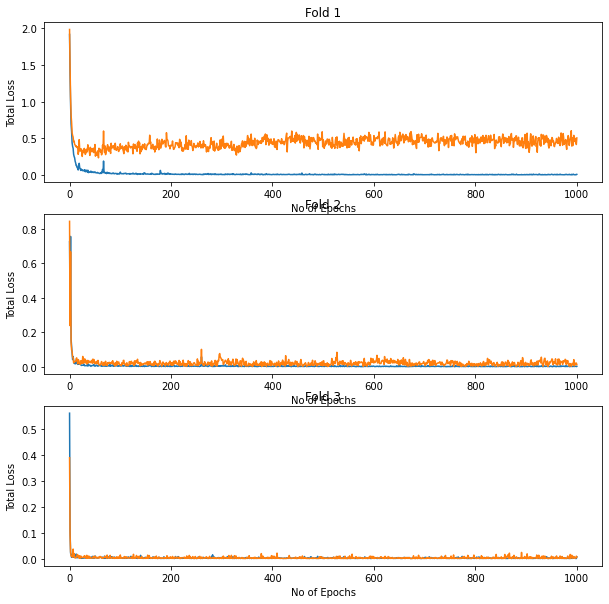

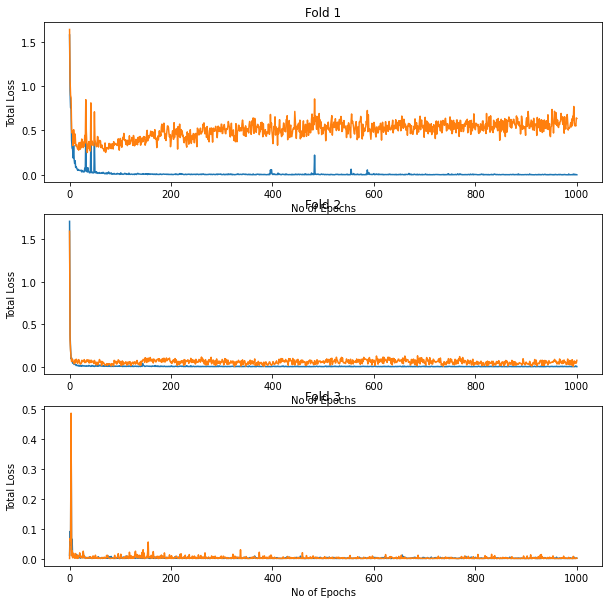

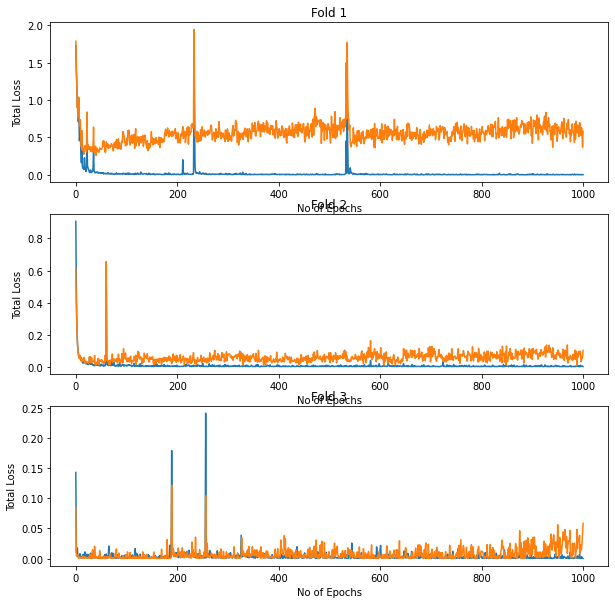

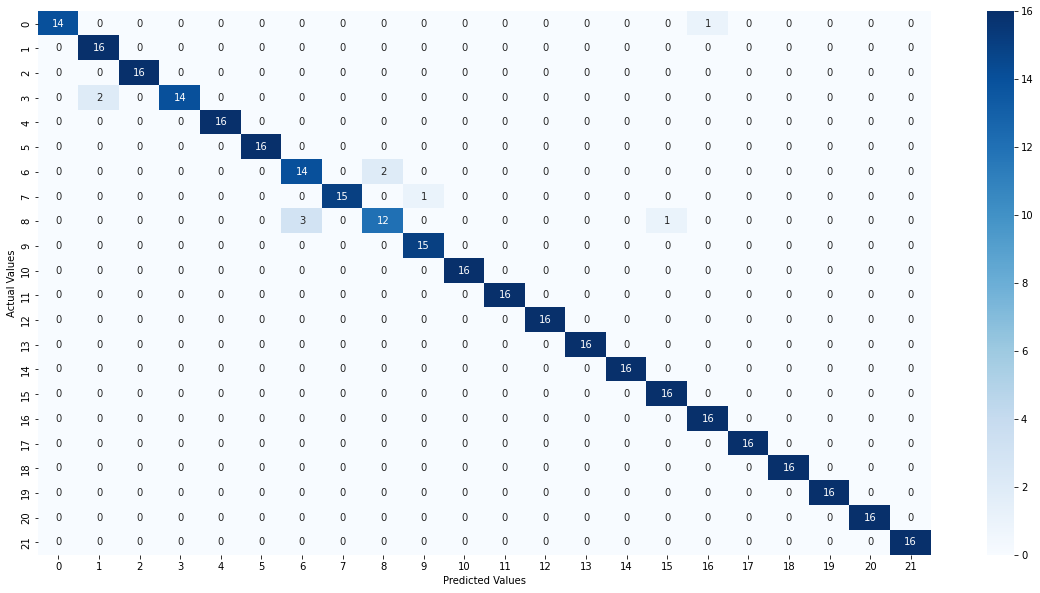

2.339550180573745e-05
Accuracy is 96.86%
Recall is 97.14%
Precision is 97.22%


In [215]:
# model training with hyperparameter tuning using features selected by existing EFS-MI algorithm
model_training_evaluation(X_train, X_test, y_train, y_test,selected_feat_efs_mi)

Training for fold 1
Training for fold 2
Training for fold 3
Training for fold 1
Training for fold 2
Training for fold 3
Training for fold 1
Training for fold 2
Training for fold 3


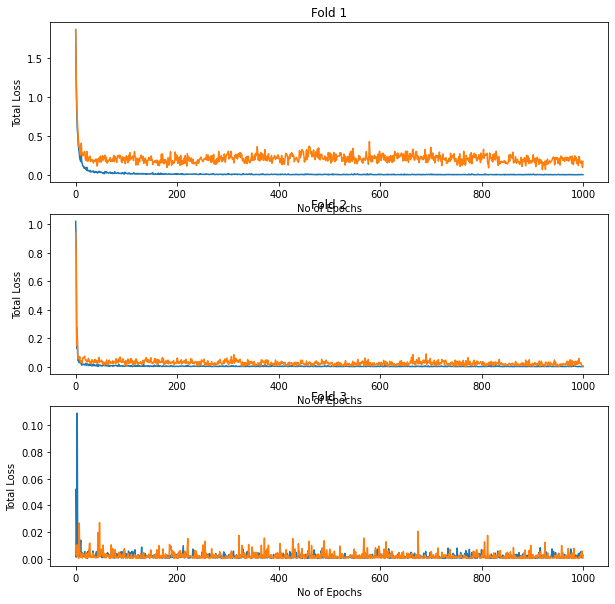

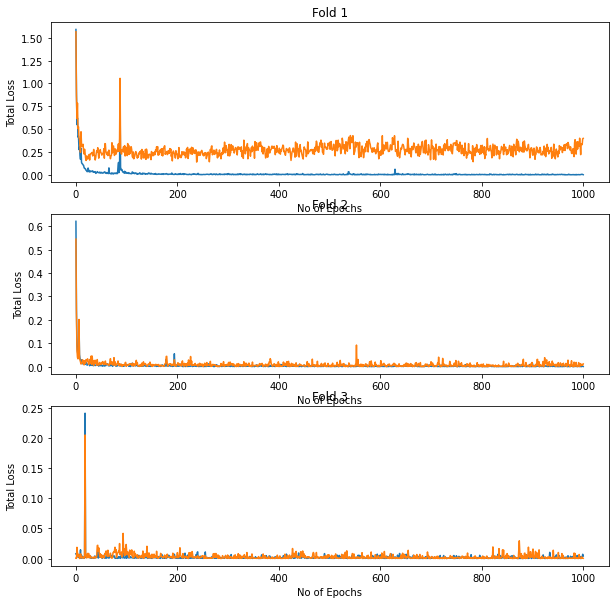

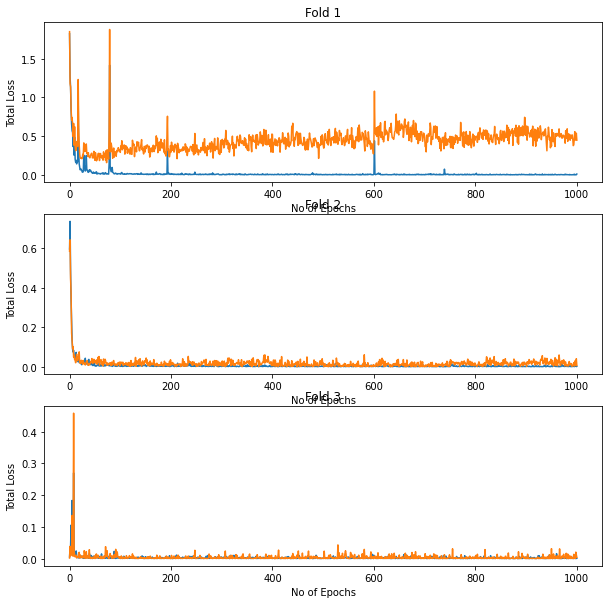

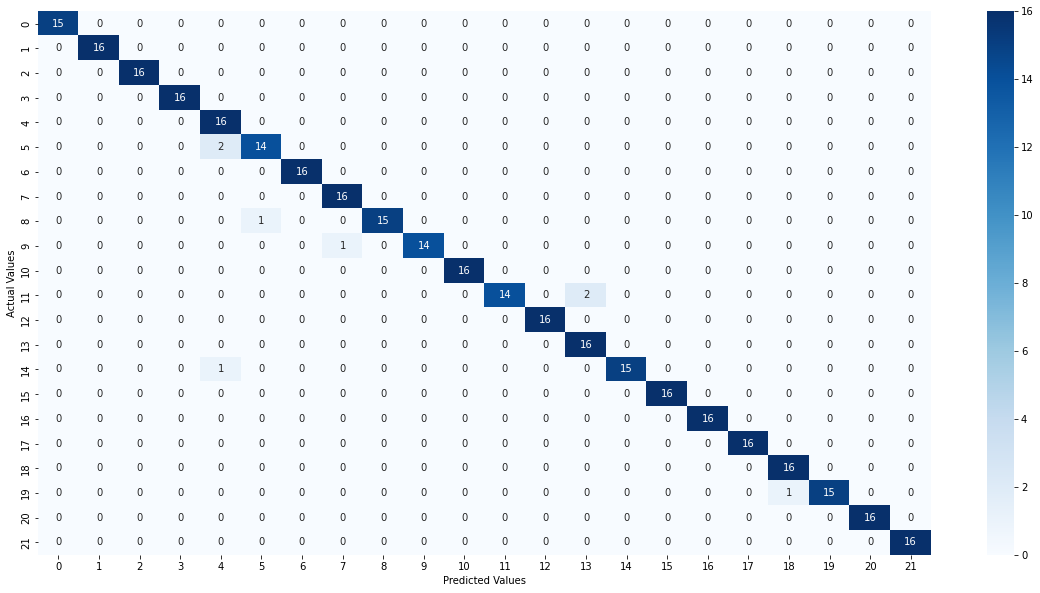

1.080202048720029e-05
Accuracy is 97.71%
Recall is 97.71%
Precision is 97.94%


In [216]:
# model training with hyperparameter tuning using features selected by proposed EBCFS algorithm
model_training_evaluation(X_train, X_test, y_train, y_test,selected_feat_ecfs)

Training for fold 1
Training for fold 2
Training for fold 3
Training for fold 1
Training for fold 2
Training for fold 3
Training for fold 1
Training for fold 2
Training for fold 3


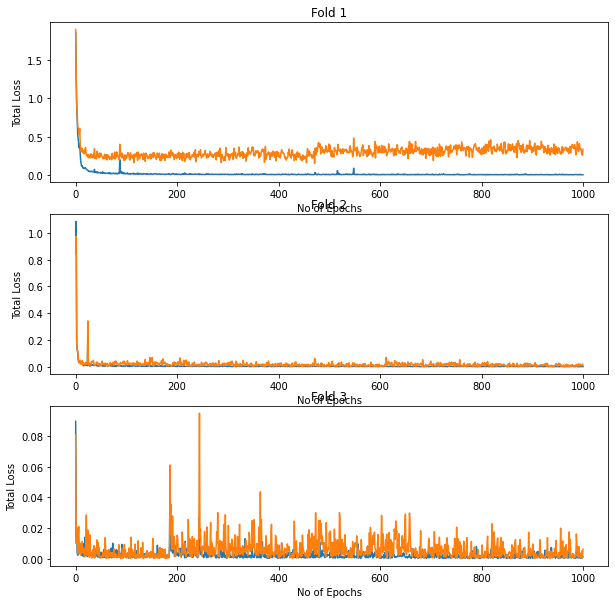

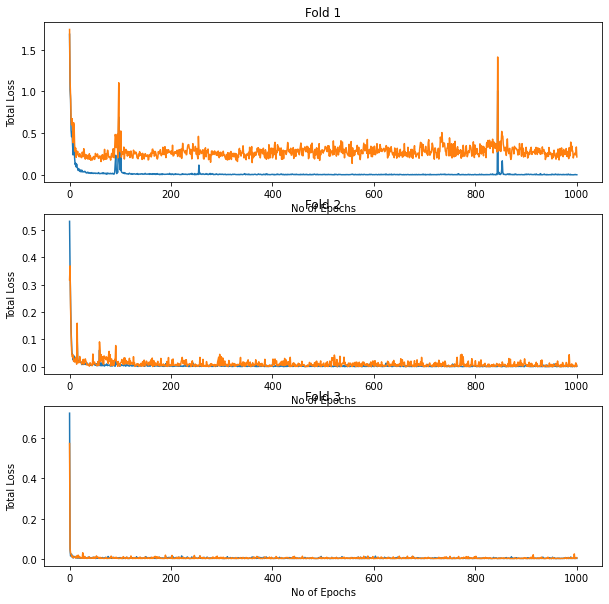

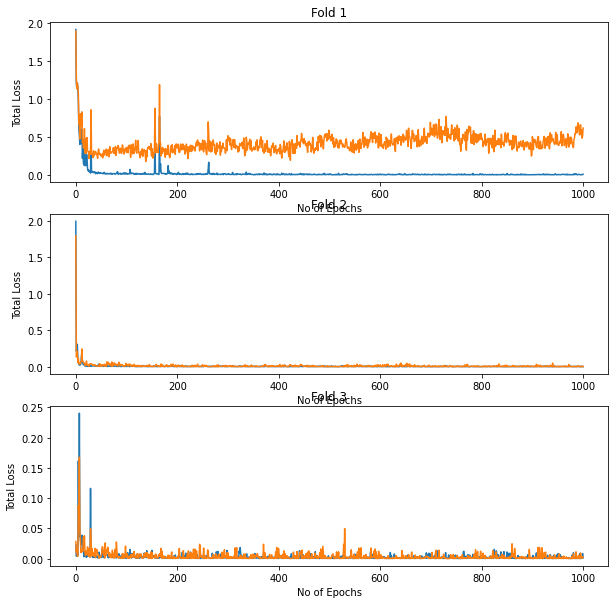

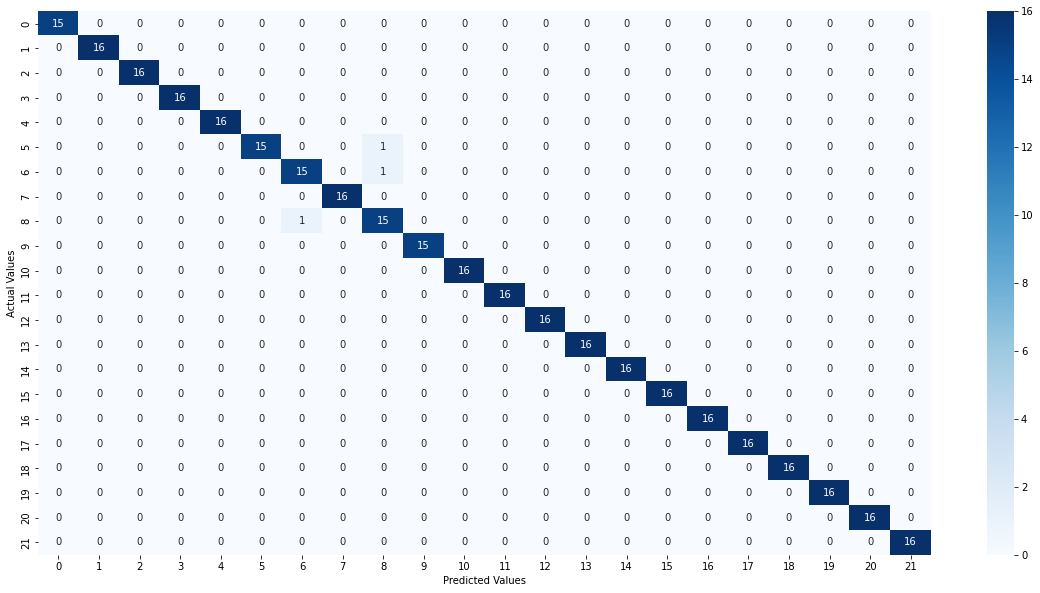

1.3853162114690591e-05
Accuracy is 98.86%
Recall is 99.15%
Precision is 99.18%


In [217]:
#training the model with all features
model_training_evaluation(X_train, X_test, y_train, y_test,features)


In [ ]:
len(selected_feat_ecfs)

In [ ]:
len(selected_feat_efs_mi)

In [ ]:
print(selected_feat_ecfs[selected_feat_ecfs not in selected_feat_efs_mi])

In [ ]:
negated = np.setdiff1d(selected_feat_ecfs,selected_feat_efs_mi)

In [ ]:
selected_feat_efs_mi

In [ ]:
 lst2 = SU_feature_selection(X_train, y_train)

In [ ]:
 left = [value for value in negated if value in lst2]

In [ ]:
len(lst2)

In [ ]:
len(negated)

In [ ]:
left

In [ ]:
negated

In [ ]:
X_train.shape

In [ ]:
len(features)